<a href="https://colab.research.google.com/github/estellacoding/likelihood-to-buy-prediction/blob/main/Likelihood_To_Buy_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

使用 H2O AutoML 建立一個「潛在用戶購買可能性」的預測模型，並以預測結果來執行行銷跟進策略。

# 載入函式庫

In [ ]:
!pip install h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.8/265.8 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.46.0.6-py2.py3-none-any.whl size=265859786 sha256=b21068a76c4cabe1b691ce2c3a85f2c257598f425bb02329554fbb1f484259f3
  Stored in directory: /root/.cache/pip/wheels/62/f9/aa/687bd54342d2981bc78e22ee9b9bc39f92006e344e7aa1e0ac
Successfully built h2o


In [ ]:
import pandas as pd
import sqlalchemy as sql
import h2o
from h2o.automl import H2OAutoML
import numpy as np

# 準備資料庫

將CSV檔案存入SQLite資料庫。

In [ ]:
# 讀取CSV檔
leads_df = pd.read_csv('/content/drive/MyDrive/ML/database/leads.csv')
transactions_df = pd.read_csv('/content/drive/MyDrive/ML/database/transactions.csv')

# 建立SQLite資料庫(若資料庫不存在，會自動建立)
sql_engine = sql.create_engine('sqlite:////content/drive/MyDrive/ML/database/leads_transactions.db')

# 將資料儲存到資料庫中，建立名為leads和transactions的資料表
leads_df.to_sql('leads', con=sql_engine, index=False, if_exists='replace')
transactions_df.to_sql('transactions', con=sql_engine, index=False, if_exists='replace')

# 查看資料庫內的資料表是否已建立
metadata = sql.MetaData()
metadata.reflect(bind=sql_engine)
print(list(metadata.tables.keys()))

['leads', 'transactions']


# 連線資料庫

In [ ]:
sql_engine = sql.create_engine('sqlite:////content/drive/MyDrive/ML/database/leads_transactions.db')
conn = sql_engine.connect()

# 資料前處理

## 查看資料欄位

leads欄位資料:
- mailchimp_id: 潛在客戶的MailChimp編號。
- user_full_name: 使用者完整姓名。
- user_email: 使用者電子郵件。
- member_rating: 訂閱者的會員評等，由MailChimp提供，是指訂閱者近期的活躍程度，如開信率、點擊率、互動時間等。
- optin_time: 使用者註冊或訂閱時間。
- country_code: 使用者所在國家代碼。
- made_purchase: 是否曾購買。
- optin_days: 訂閱天數。
- email_provider: 電子郵件提供商，如Gmail、Hotmail等。

In [ ]:
leads_df = pd.read_sql_table('leads', conn)
leads_df

,mailchimp_id,user_full_name,user_email,member_rating,optin_time,country_code,made_purchase,optin_days,email_provider
0,3,Garrick Langworth,garrick.langworth@gmail.com,2,2019-05-22 00:00:00.000000,in,1,-589,gmail.com
1,4,Cordell Dickens,cordell.dickens@gmail.com,4,2018-11-19 00:00:00.000000,other,1,-773,gmail.com
2,8,Inga Dach,inga.dach@gmail.com,2,2018-11-19 00:00:00.000000,other,1,-773,gmail.com
3,10,Ferdinand Bergstrom,ferdinand.bergstrom@gmail.com,2,2020-03-20 00:00:00.000000,co,1,-286,gmail.com
4,11,Justen Simonis,justen.simonis@gmail.com,2,2020-04-14 00:00:00.000000,other,0,-261,gmail.com
...,...,...,...,...,...,...,...,...,...
19914,33405,Ms. Felicity Moore MD,ms.felicity.moore.md@gmail.com,2,2018-11-18 00:00:00.000000,other,0,-774,gmail.com
19915,33406,Shirley Rowe,shirley.rowe@gmail.com,1,2019-03-12 00:00:00.000000,br,0,-660,gmail.com
19916,33407,Jarrett Walker-Carroll,jarrett.walkercarroll@gmail.com,2,2019-09-09 00:00:00.000000,in,0,-479,gmail.com
19917,33408,Tanja Herzog,tanja.herzog@gmail.com,2,2019-10-24 00:00:00.000000,other,0,-434,gmail.com


transactions欄位資料:
- transaction_id: 交易編號。
- purchased_at: 購買日期。
- user_full_name: 購買者的姓名。
- user_email: 購買者電子郵件。
- charge_country: 付款國家。
- product_id: 購買產品的編號。

In [ ]:
transactions_df = pd.read_sql_table('transactions', conn)
transactions_df

,transaction_id,purchased_at,user_full_name,user_email,charge_country,product_id
0,1,2018-04-29,Deliah Kemmer,deliah.kemmer@gmail.com,US,31.0
1,2,2018-04-29,Dr. Ronal Keeling DVM,dr.ronal.keeling.dvm@gmail.com,NZ,31.0
2,3,2018-04-29,Taya Ondricka-Orn,taya.ondrickaorn@hotmail.com,US,31.0
3,4,2018-04-29,Camren Auer DDS,camren.auer.dds@live.com,AU,31.0
4,5,2018-04-29,Dr Janna Glover Ph.D.,dr.janna.glover.phd@gmail.com,GB,31.0
...,...,...,...,...,...,...
4657,4658,2020-12-31,Bedford Farrell,bedford.farrell@yahoo.com,US,41.0
4658,4659,2020-12-31,Michelina Pfannerstill,michelina.pfannerstill@gmail.com,IN,41.0
4659,4660,2020-12-31,Mrs. Irene Feil PhD,mrs.irene.feil.phd@gmail.com,US,23.0
4660,4661,2020-12-31,Conner Carroll,conner.carroll@gmail.com,AU,1.0


## 刪除不需要欄位

In [ ]:
df = leads_df.drop(columns=['mailchimp_id', 'made_purchase', 'user_full_name'])
df

,user_email,member_rating,optin_time,country_code,optin_days,email_provider
0,garrick.langworth@gmail.com,2,2019-05-22 00:00:00.000000,in,-589,gmail.com
1,cordell.dickens@gmail.com,4,2018-11-19 00:00:00.000000,other,-773,gmail.com
2,inga.dach@gmail.com,2,2018-11-19 00:00:00.000000,other,-773,gmail.com
3,ferdinand.bergstrom@gmail.com,2,2020-03-20 00:00:00.000000,co,-286,gmail.com
4,justen.simonis@gmail.com,2,2020-04-14 00:00:00.000000,other,-261,gmail.com
...,...,...,...,...,...,...
19914,ms.felicity.moore.md@gmail.com,2,2018-11-18 00:00:00.000000,other,-774,gmail.com
19915,shirley.rowe@gmail.com,1,2019-03-12 00:00:00.000000,br,-660,gmail.com
19916,jarrett.walkercarroll@gmail.com,2,2019-09-09 00:00:00.000000,in,-479,gmail.com
19917,tanja.herzog@gmail.com,2,2019-10-24 00:00:00.000000,other,-434,gmail.com


## 新增預測目標欄位

針對每個潛在客戶的電子郵件，檢查是否存在於交易記錄中（transactions_df）中：
- 若存在，表示顧客曾購買產品，則標示為`1`。
- 若不存在，表示顧客未曾購買產品，則標示為`0`。

In [ ]:
target_emails = transactions_df['user_email'].unique()
df['purchased'] = df['user_email'].isin(target_emails).astype(int)
df

,user_email,member_rating,optin_time,country_code,optin_days,email_provider,purchased
0,garrick.langworth@gmail.com,2,2019-05-22 00:00:00.000000,in,-589,gmail.com,1
1,cordell.dickens@gmail.com,4,2018-11-19 00:00:00.000000,other,-773,gmail.com,1
2,inga.dach@gmail.com,2,2018-11-19 00:00:00.000000,other,-773,gmail.com,1
3,ferdinand.bergstrom@gmail.com,2,2020-03-20 00:00:00.000000,co,-286,gmail.com,1
4,justen.simonis@gmail.com,2,2020-04-14 00:00:00.000000,other,-261,gmail.com,0
...,...,...,...,...,...,...,...
19914,ms.felicity.moore.md@gmail.com,2,2018-11-18 00:00:00.000000,other,-774,gmail.com,0
19915,shirley.rowe@gmail.com,1,2019-03-12 00:00:00.000000,br,-660,gmail.com,0
19916,jarrett.walkercarroll@gmail.com,2,2019-09-09 00:00:00.000000,in,-479,gmail.com,0
19917,tanja.herzog@gmail.com,2,2019-10-24 00:00:00.000000,other,-434,gmail.com,0


# H2O AutoML模型訓練

## 設定H2O

啟動H2O環境。

In [ ]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.26" 2025-01-21; OpenJDK Runtime Environment (build 11.0.26+4-post-Ubuntu-1ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.26+4-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.11/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpgnunpagu
  JVM stdout: /tmp/tmpgnunpagu/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpgnunpagu/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,3 months and 22 days
H2O_cluster_name:,H2O_from_python_unknownUser_bvpf32
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


## 資料轉為H2O

將資料轉為H2O格式並設定目標變數。

In [ ]:
hf = h2o.H2OFrame(df)
hf['purchased'] = hf['purchased'].asfactor()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


設定特徵及目標。

In [ ]:
predictors = ['member_rating', 'optin_time', 'country_code', 'optin_days', 'email_provider']
target = "purchased"

## 建立模型

- `max_models=20`: 訓練模型數量最多為20個。
- `max_runtime_secs=600`: 設定訓練10分鐘。

In [ ]:
automl = H2OAutoML(max_models=20, seed=1, max_runtime_secs=600)
automl.train(x=predictors, y=target, training_frame=hf)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OXGBoostEstimator : XGBoost
Model Key: XGBoost_1_AutoML_1_20250224_55852


Model Summary: 
    number_of_trees
--  -----------------
    46

ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.039021343983723804
RMSE: 0.19753820892101812
LogLoss: 0.15022286702814347
Mean Per-Class Error: 0.3291061003911138
AUC: 0.8410526854900965
AUCPR: 0.3187731581471456
Gini: 0.682105370980193

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15667875558137895
       0      1     Error    Rate
-----  -----  ----  -------  ----------------
0      18086  871   0.0459   (871.0/18957.0)
1      589    373   0.6123   (589.0/962.0)
Total  18675  1244  0.0733   (1460.0/19919.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.156679     0.338169  156
max f2                       0.0959474    0.435662  215
max f0point5                 0.294607     0.388612  81
max accuracy                 0.331482     0.954466  66
max precision                0.846606     1         0
max recall                   0.00471898   1         393
max specificity              0.846606     1         0
max absolute_mcc             0.230512     0.305909  111
max min_per_class_accuracy   0.0523514    0.769637  274
max mean_per_class_accuracy  0.0575211    0.774315  266
max tns                      0.846606     18957     0
max fns                      0.846606     958       0
max fps                      0.000317201  18957     399
max tps                      0.00471898   962       393
max tnr                      0.846606     1         0
max fnr                      0.846606     0.995842  0
max fpr                      0.000317201  1         399
max tpr                      0.00471898   1         393

Gains/Lift Table: Avg response rate:  4.83 %, avg score:  4.83 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100909                   0.338836           12.6707    12.6707            0.61194          0.477965    0.61194                     0.477965            0.127859        0.127859                   1167.07   1167.07            0.123744
2        0.0200311                   0.283675           7.73854    10.2232            0.373737         0.312976    0.493734                    0.396091            0.0769231       0.204782                   673.854   922.317            0.194126
3        0.0309252                   0.24102            5.1526     8.43695            0.248848         0.258492    0.407468                    0.347618            0.0561331       0.260915                   415.26    743.695            0.241661
4        0.0404137                   0.215484           4.05352    7.4078             0.195767         0.226195    0.357764                    0.31911             0.0384615       0.299376                   305.352   640.78             0.272104
5        0.0505045                   0.181657           4.53262    6.83333            0.218905         0.196748    0.33002                     0.294662            0.045738        0.345114                   353.262   583.333            0.30956
6        0.100005                    0.117326           3.19197    5.03093            0.154158         0.142265    0.242972                    0.219228            0.158004        0.503119                   219.197   403.093            0.42357
7        0.162709                    0.0834828          2.13855    3.9162

In [ ]:
lb = automl.leaderboard
print(lb)

model_id                                             auc    logloss     aucpr    mean_per_class_error      rmse        mse
XGBoost_1_AutoML_1_20250224_55852               0.769309   0.168819  0.203925                0.360477  0.20612   0.0424854
XGBoost_grid_1_AutoML_1_20250224_55852_model_1  0.76904    0.169267  0.201281                0.37696   0.206404  0.0426025
XGBoost_3_AutoML_1_20250224_55852               0.768539   0.168618  0.208026                0.357415  0.205604  0.0422729
XGBoost_grid_1_AutoML_1_20250224_55852_model_2  0.767608   0.169321  0.201701                0.39079   0.206142  0.0424945
GBM_grid_1_AutoML_1_20250224_55852_model_2      0.767035   0.169587  0.169714                0.356085  0.20713   0.0429027
GBM_grid_1_AutoML_1_20250224_55852_model_1      0.766487   0.168806  0.202308                0.360108  0.205854  0.042376
XGBoost_grid_1_AutoML_1_20250224_55852_model_3  0.765778   0.168854  0.208428                0.376456  0.205557  0.0422537
XGBoost_2_AutoML_

## 儲存模型

In [ ]:
h2o.save_model(automl.leader, path="/content/drive/MyDrive/ML/model", filename='best_model_h2o', force=True)

'/content/drive/MyDrive/ML/model/best_model_h2o'

## 模型資訊

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## XGBoost_1_AutoML_1_20250224_55852

,0,1,Error,Rate
0,18084.0,873.0,0.0461,(873.0/18957.0)
1,587.0,375.0,0.6102,(587.0/962.0)
Total,18671.0,1248.0,0.0733,(1460.0/19919.0)


# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

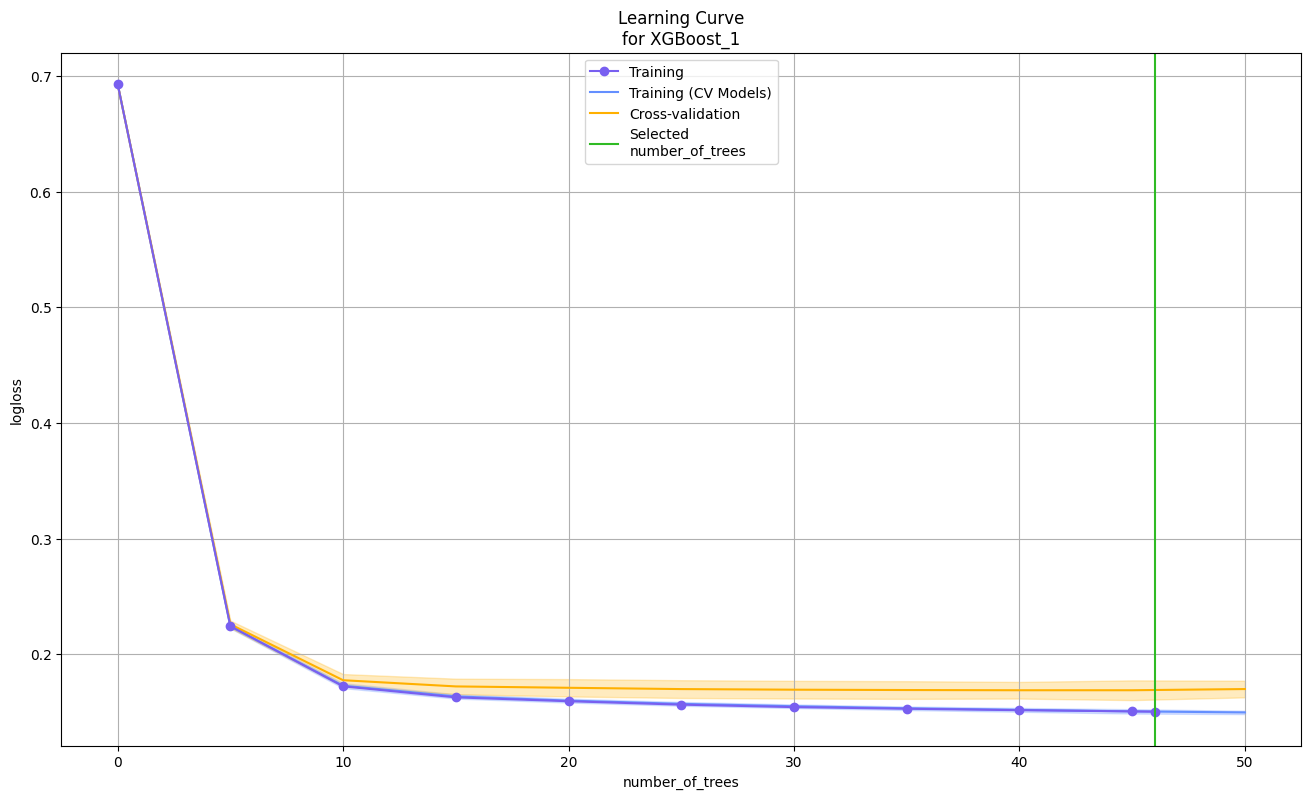

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

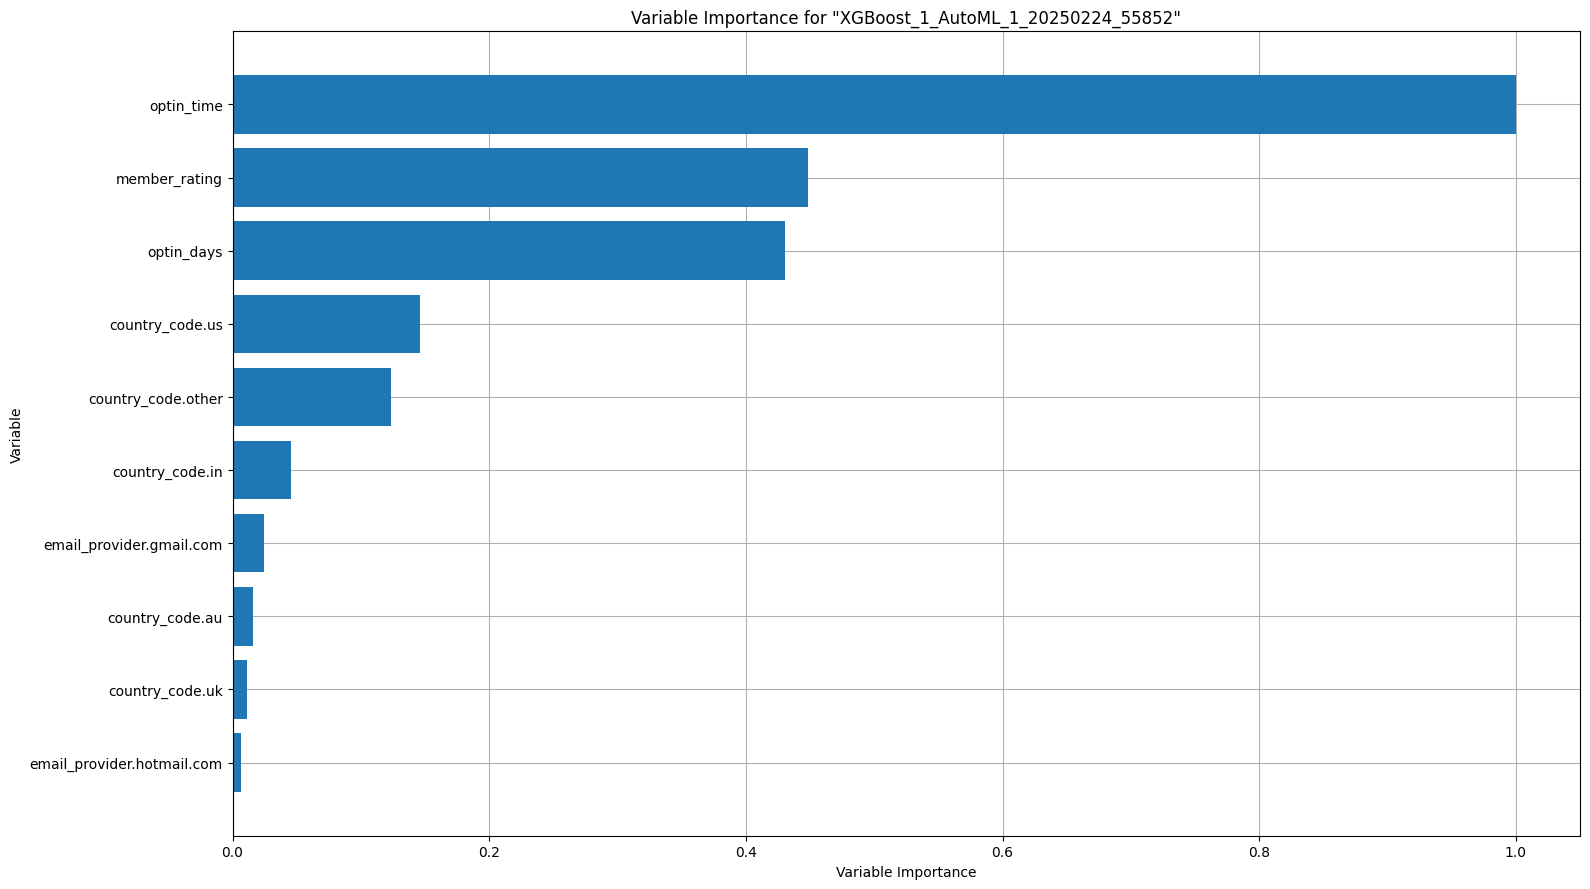

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

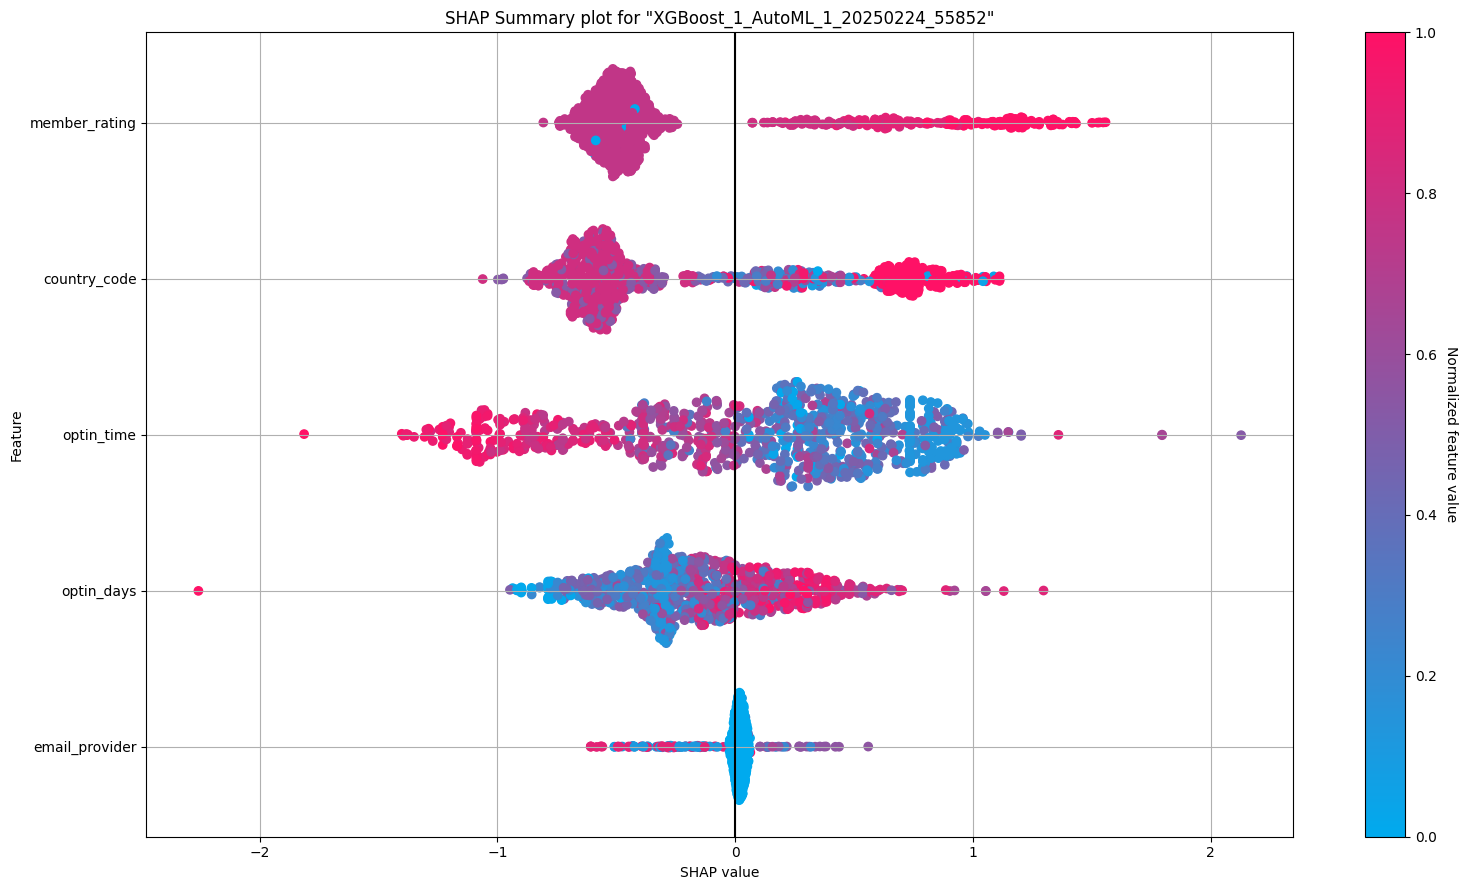

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

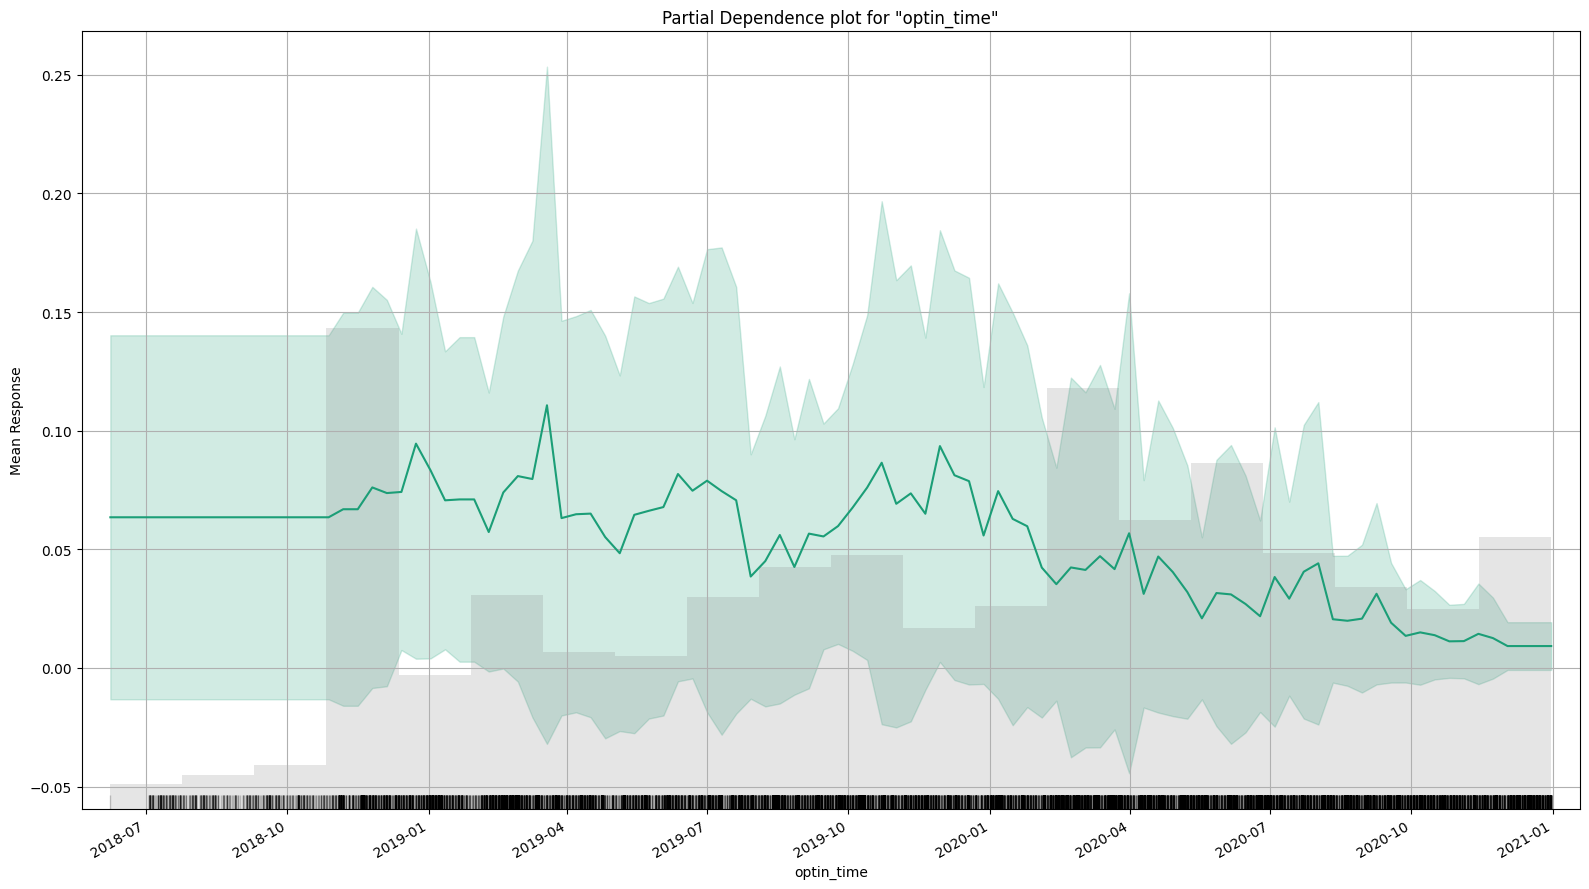

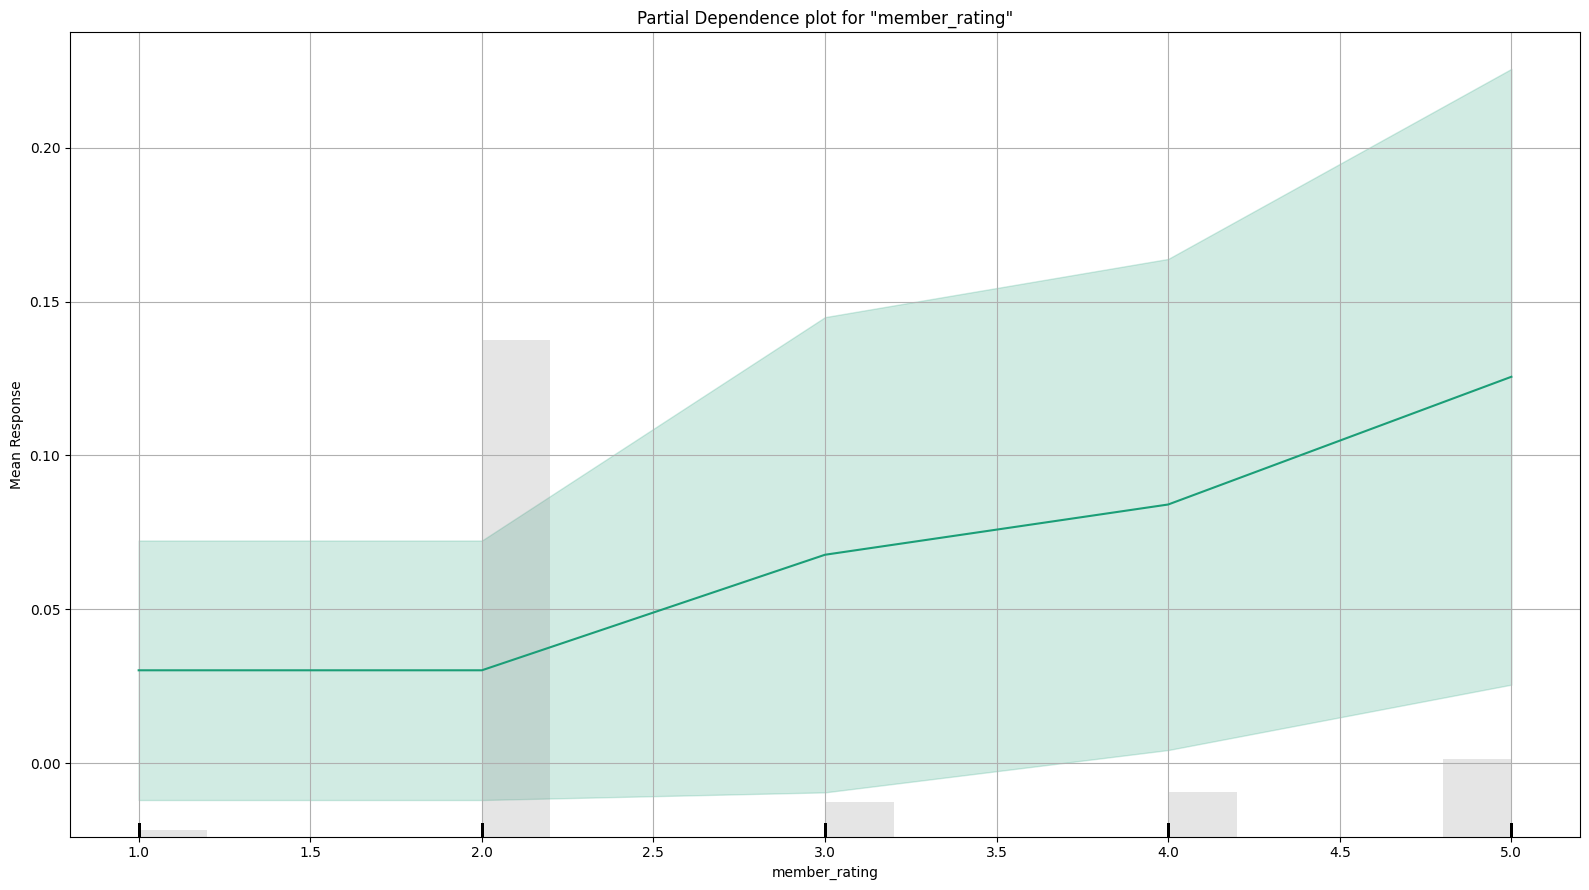

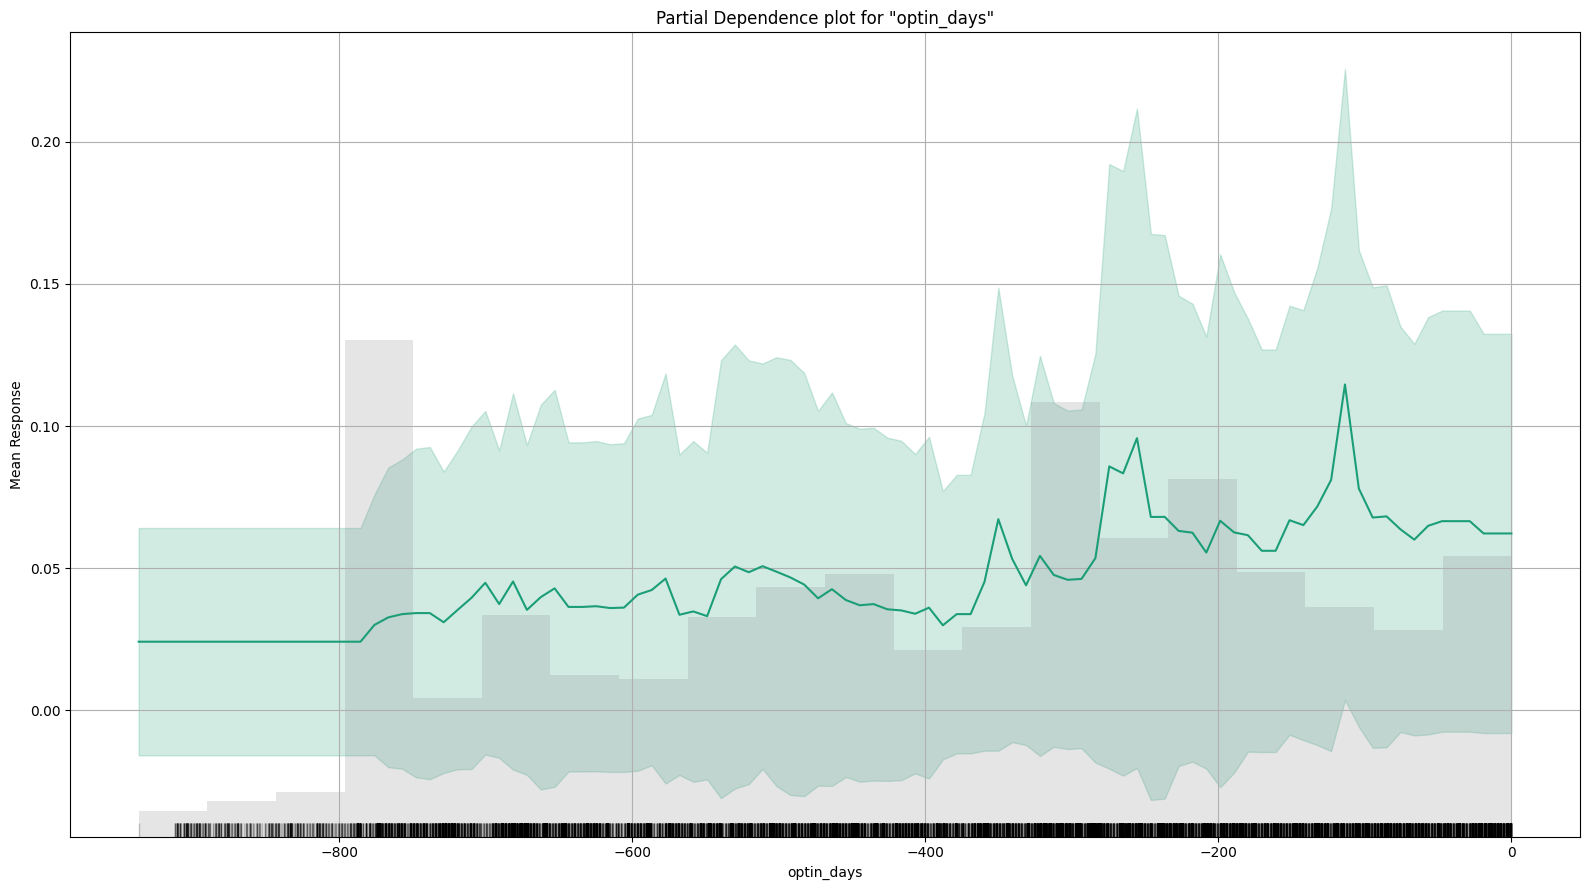

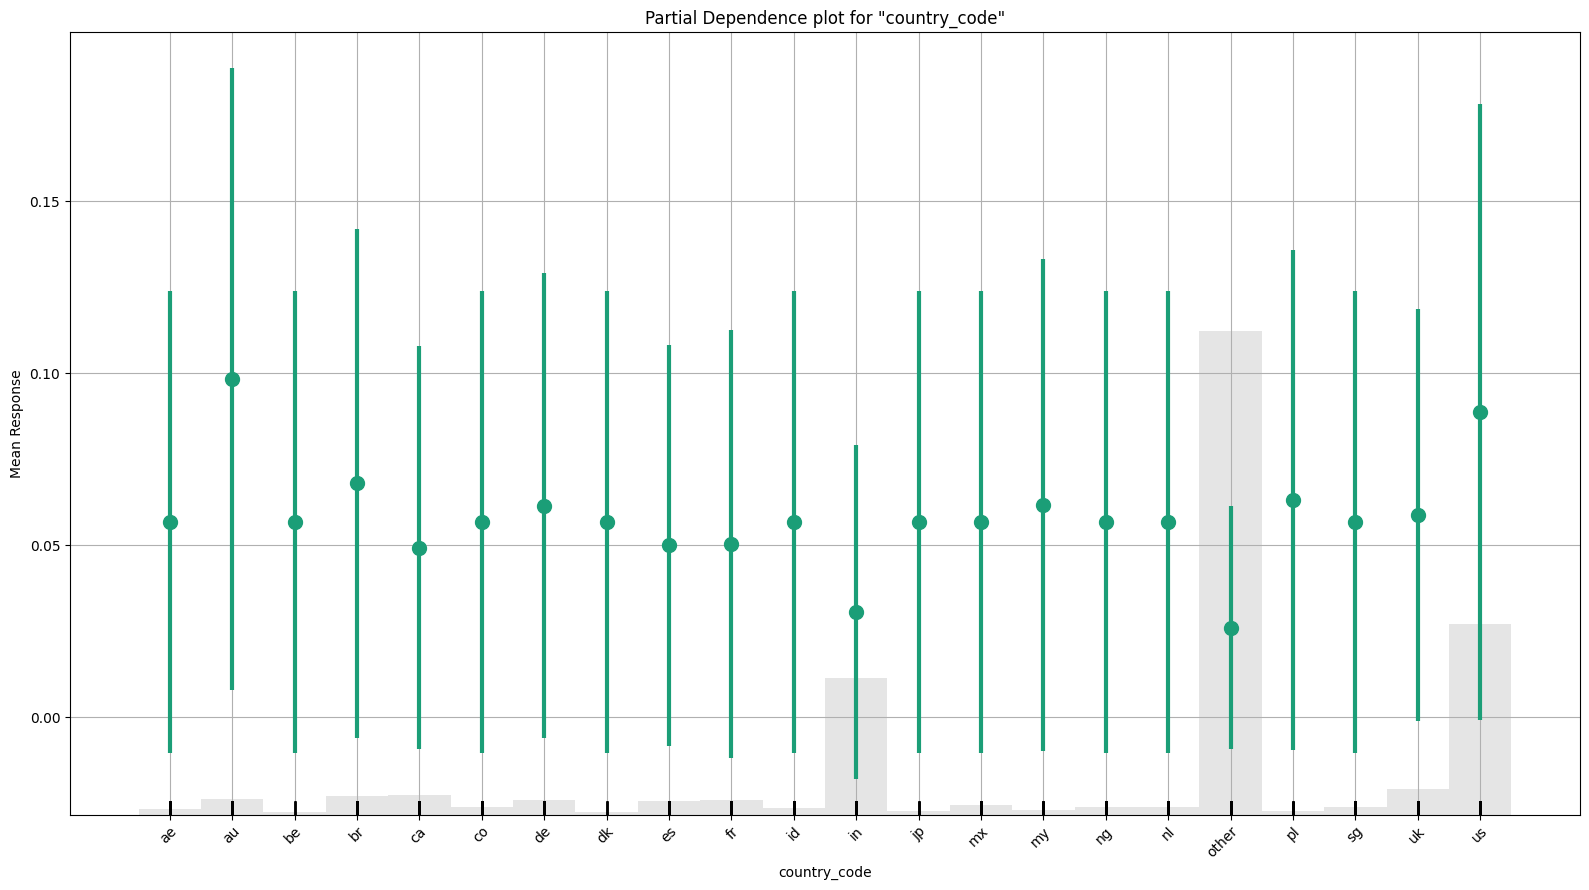

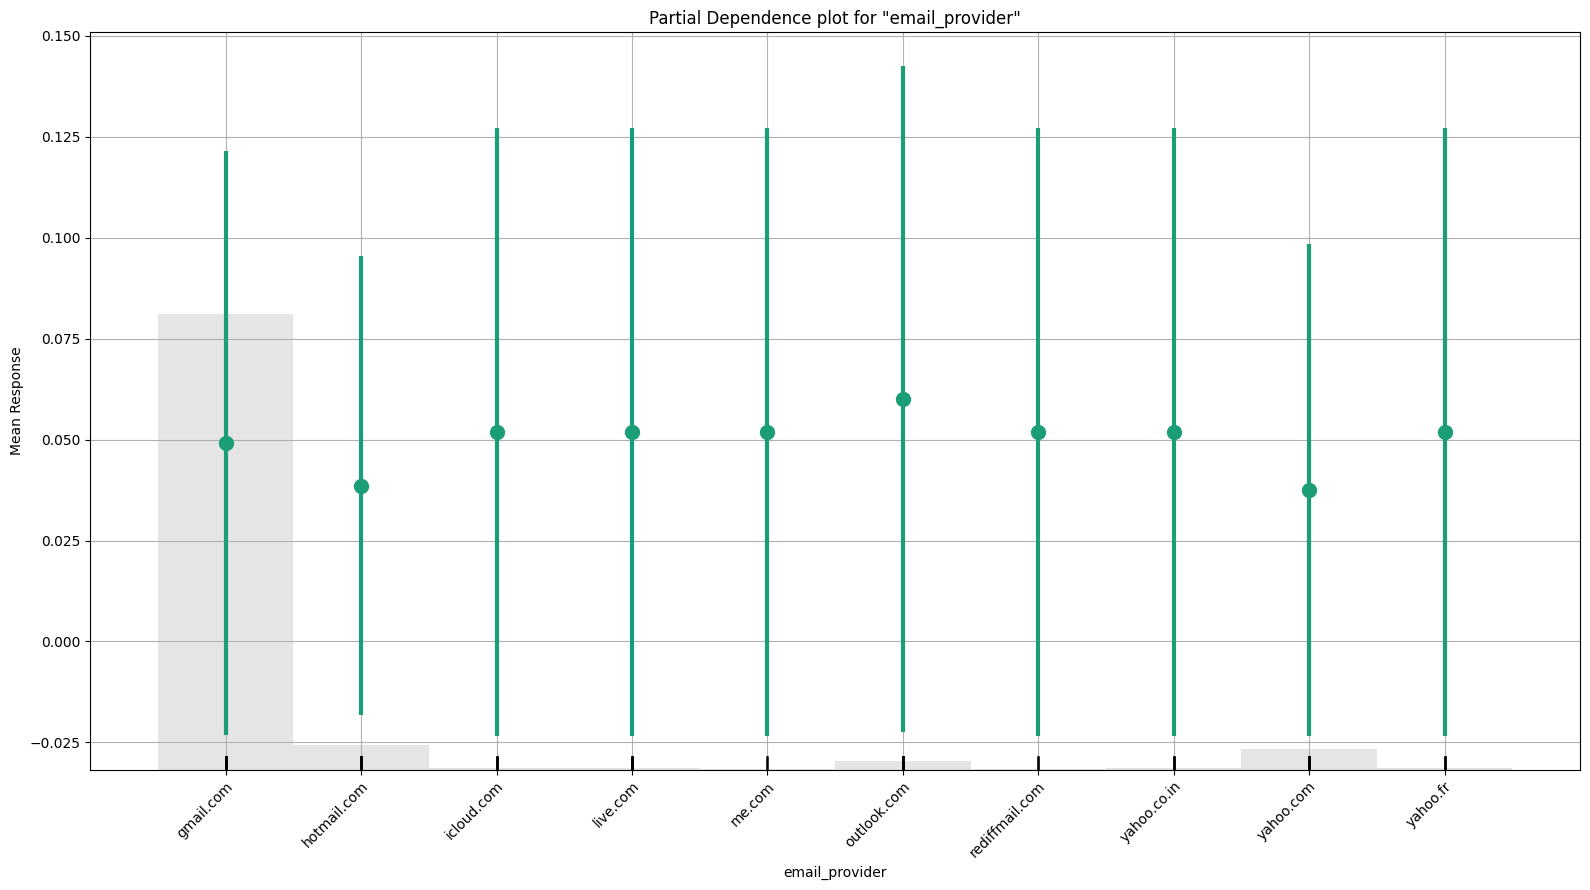

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## XGBoost_1_AutoML_1_20250224_55852

,0,1,Error,Rate
0,18084.0,873.0,0.0461,(873.0/18957.0)
1,587.0,375.0,0.6102,(587.0/962.0)
Total,18671.0,1248.0,0.0733,(1460.0/19919.0)


# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

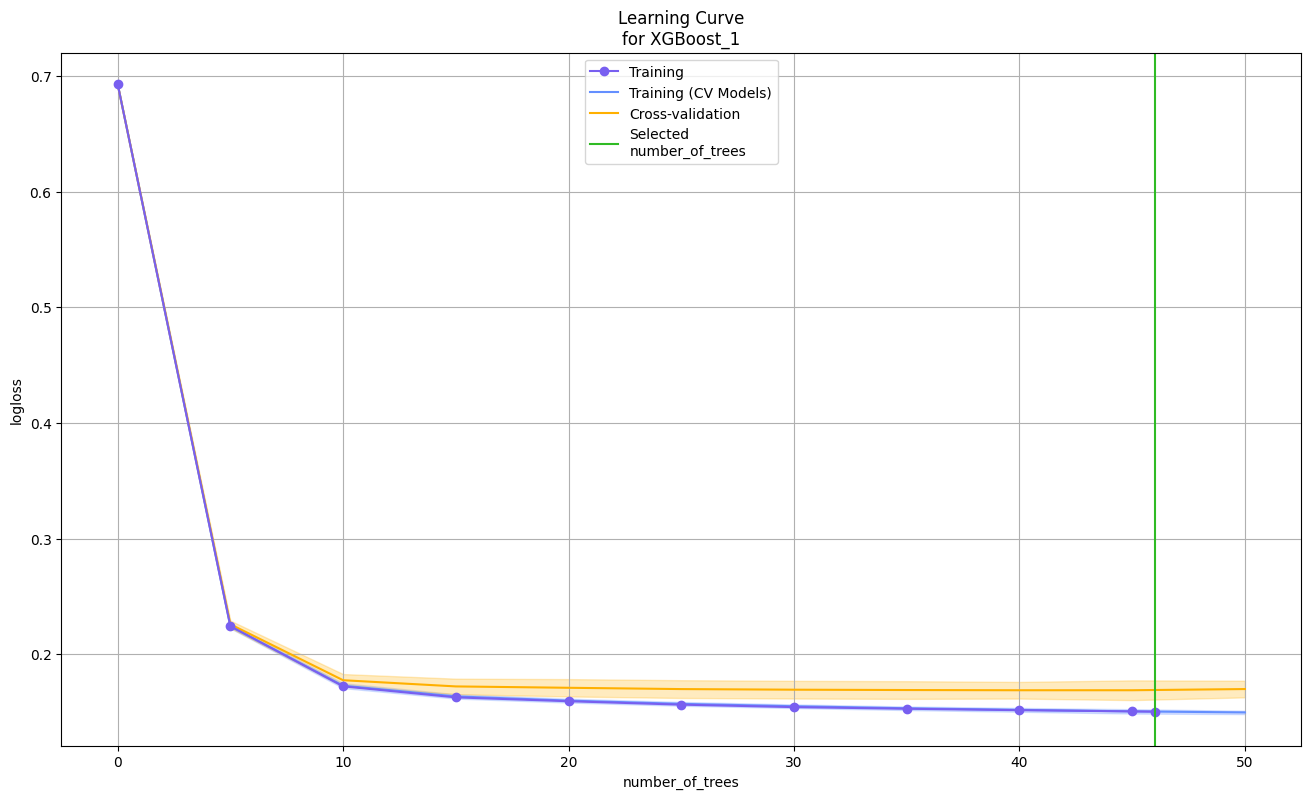

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

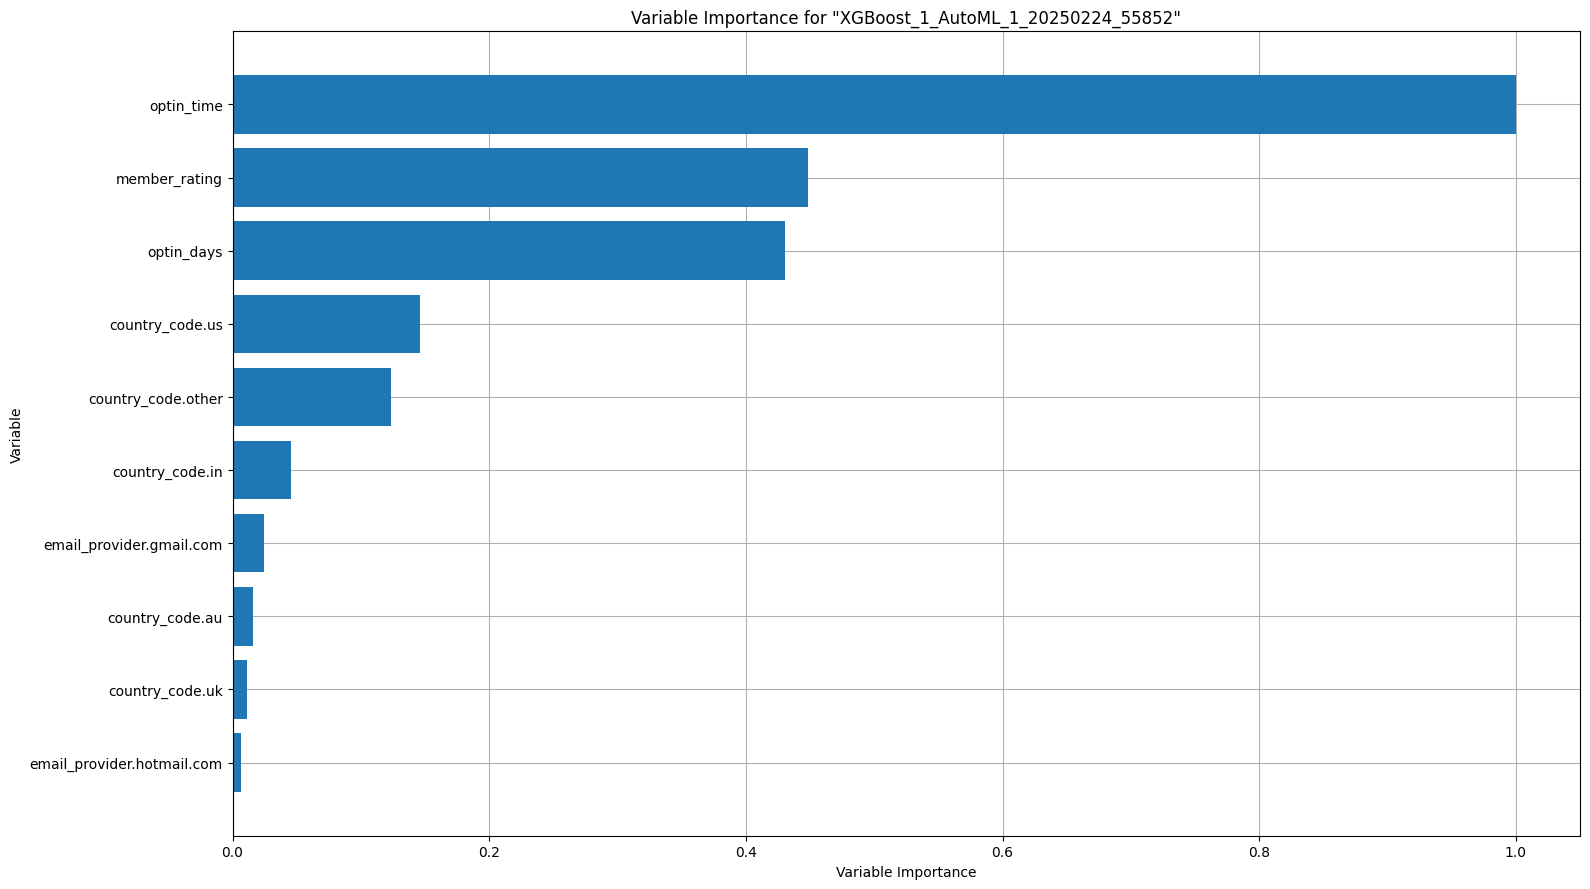

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

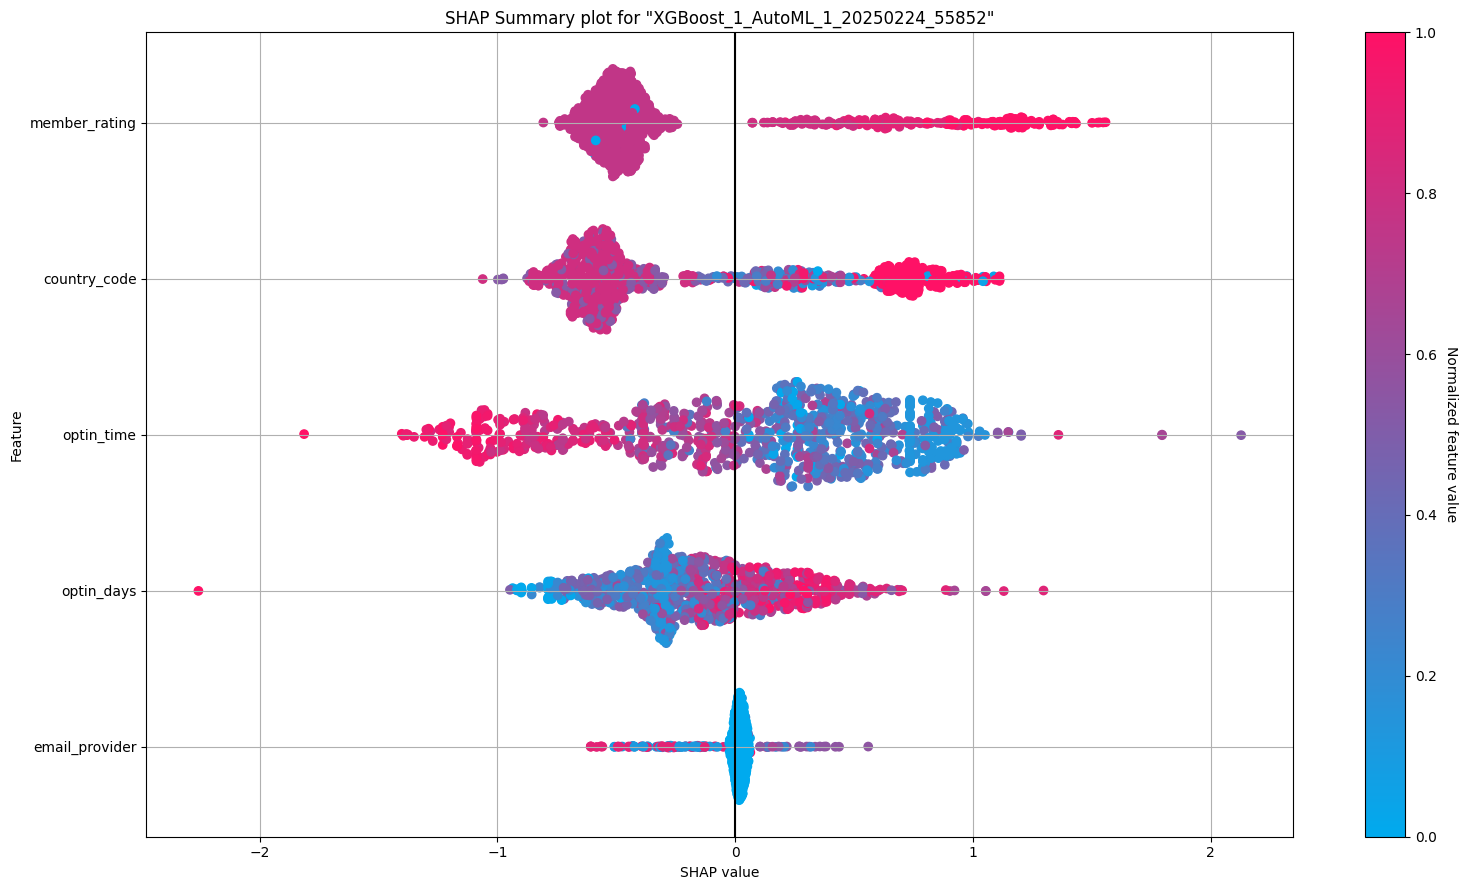

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

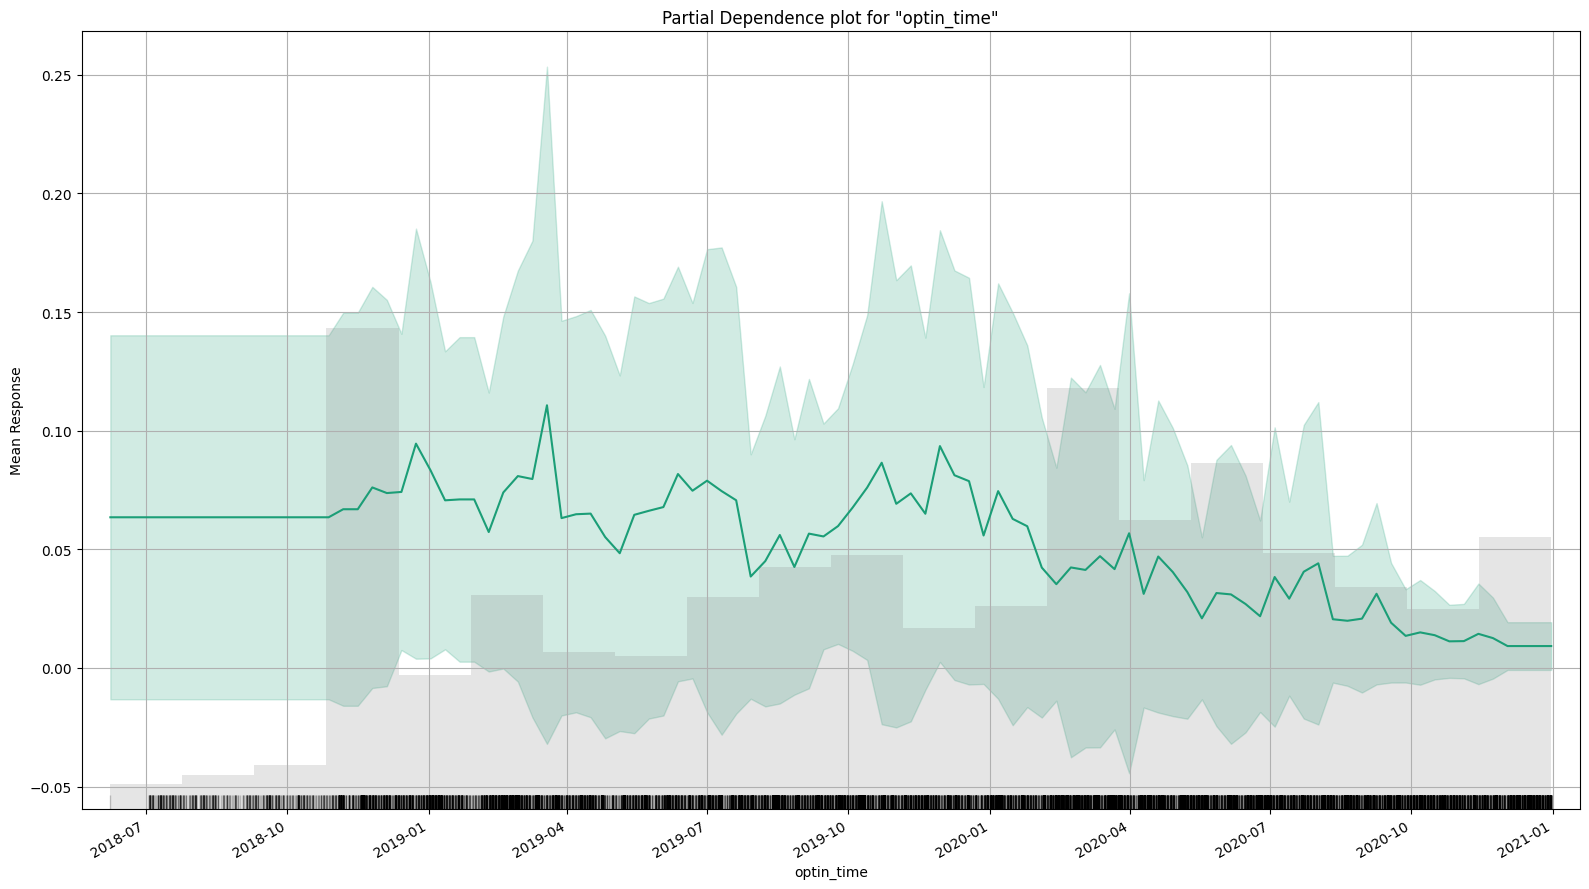

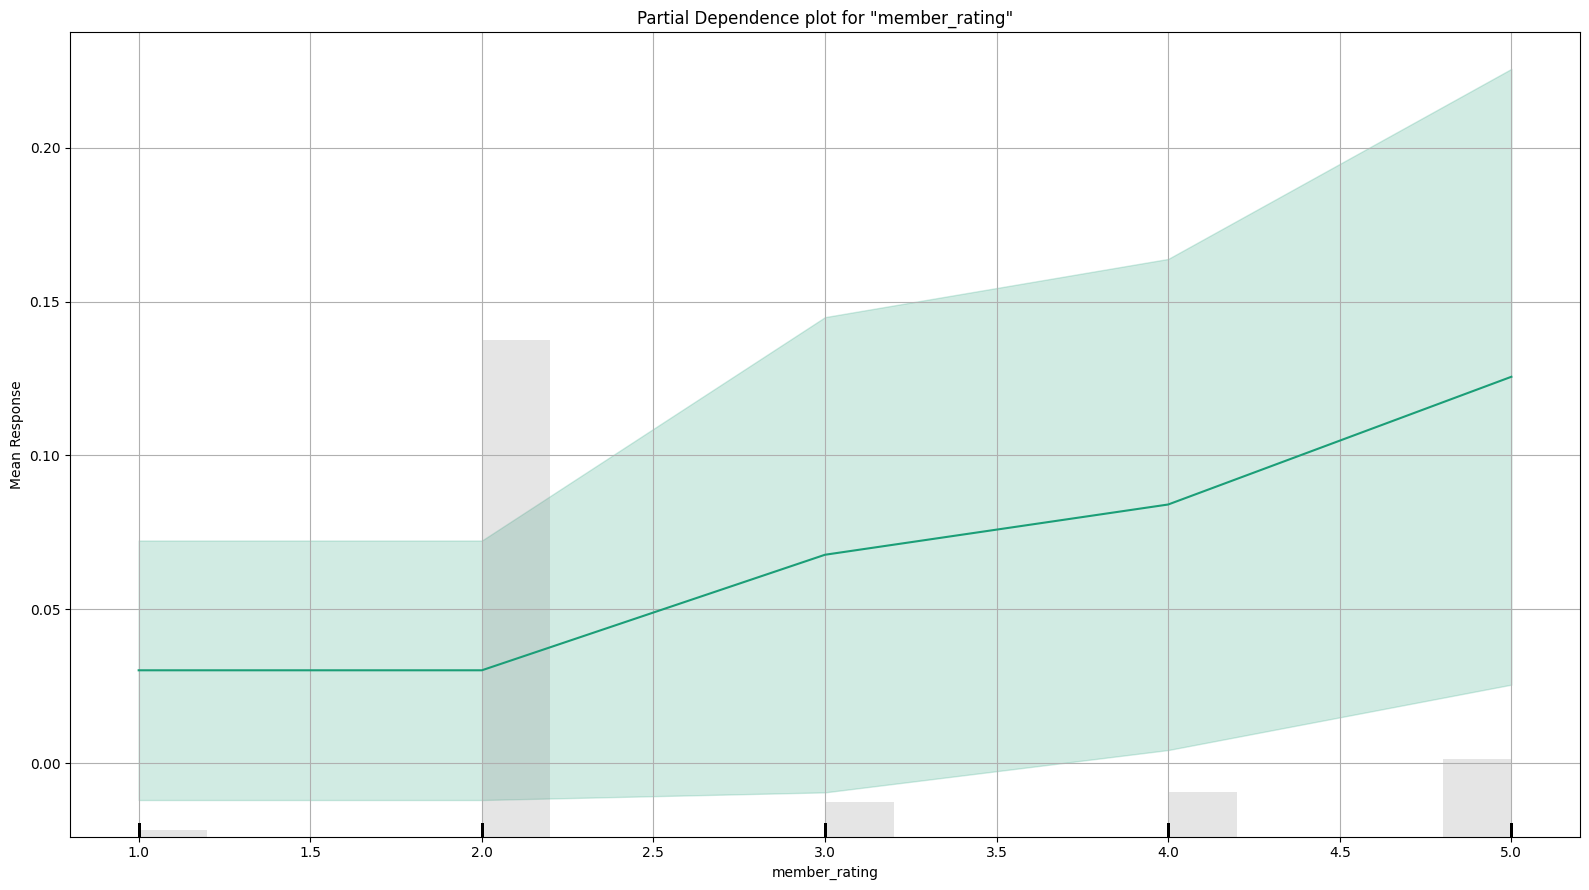

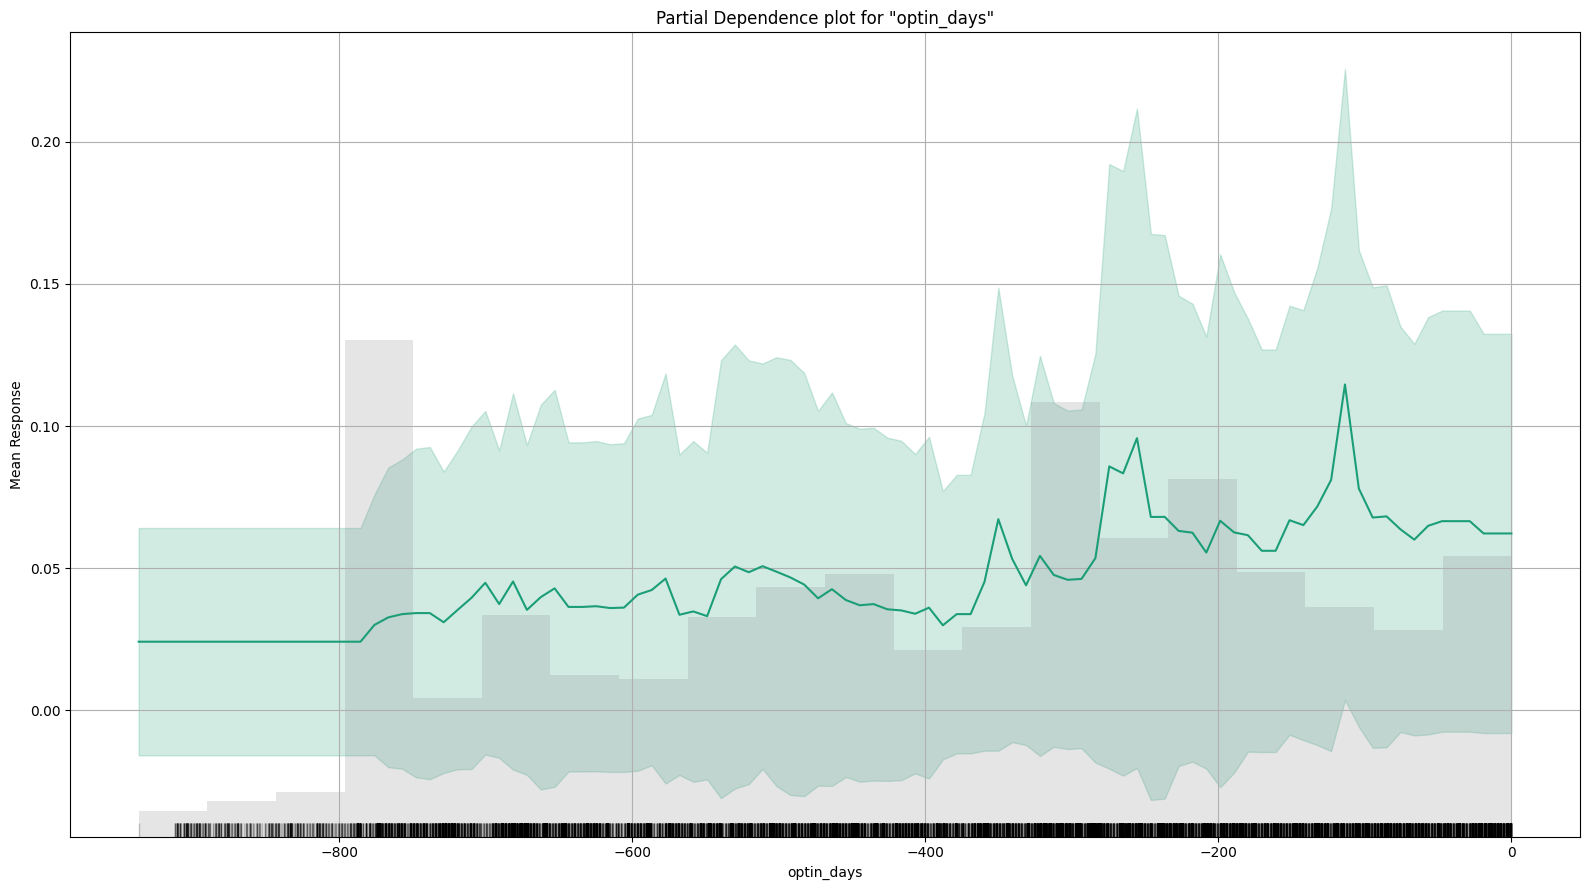

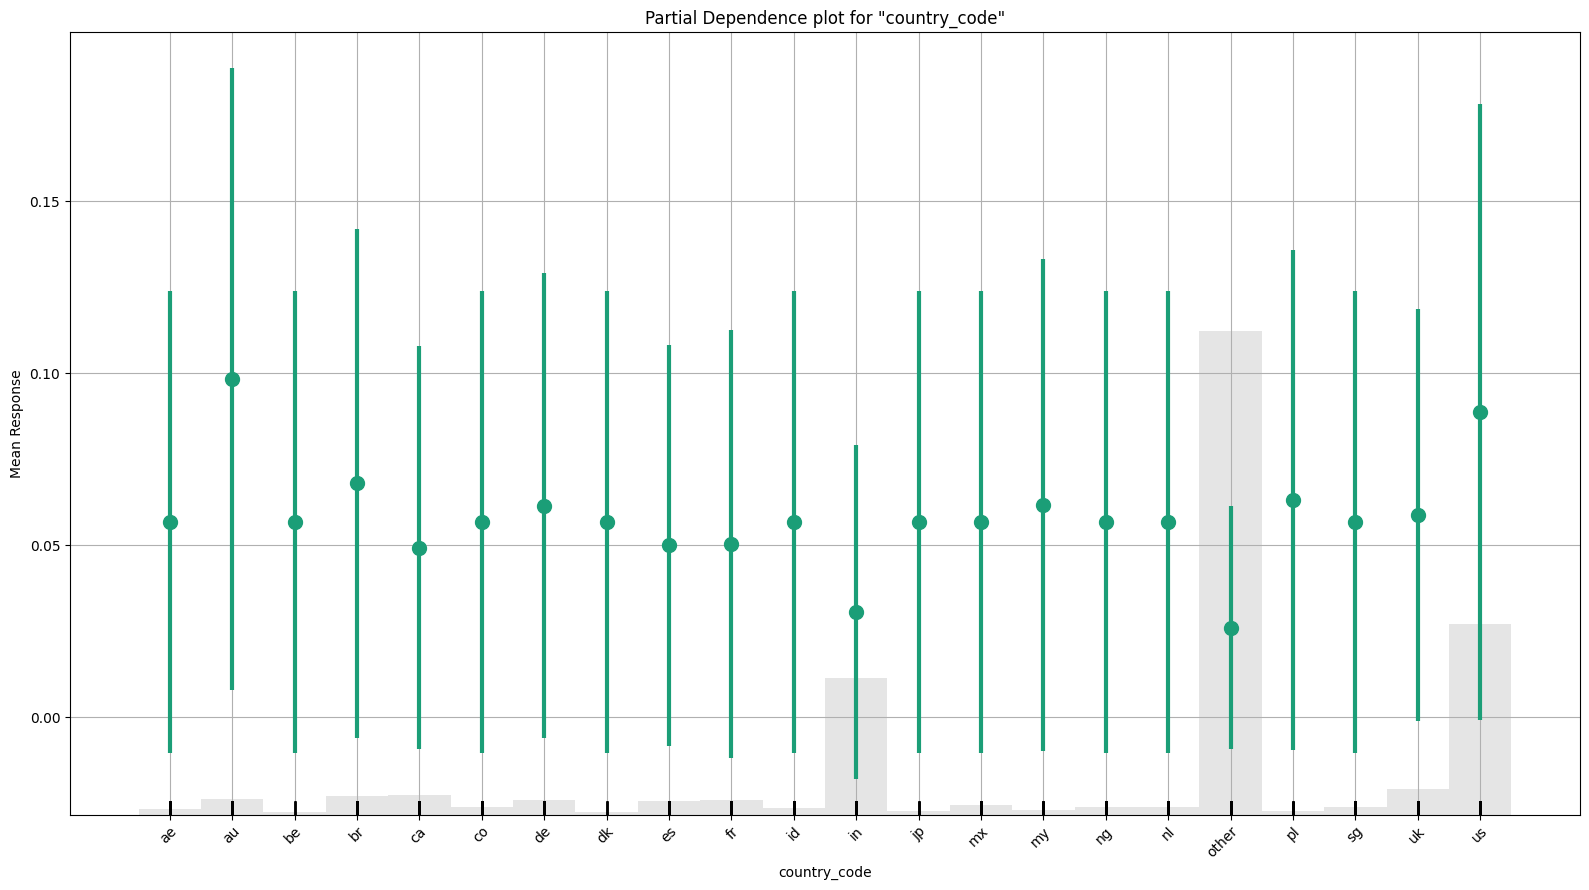

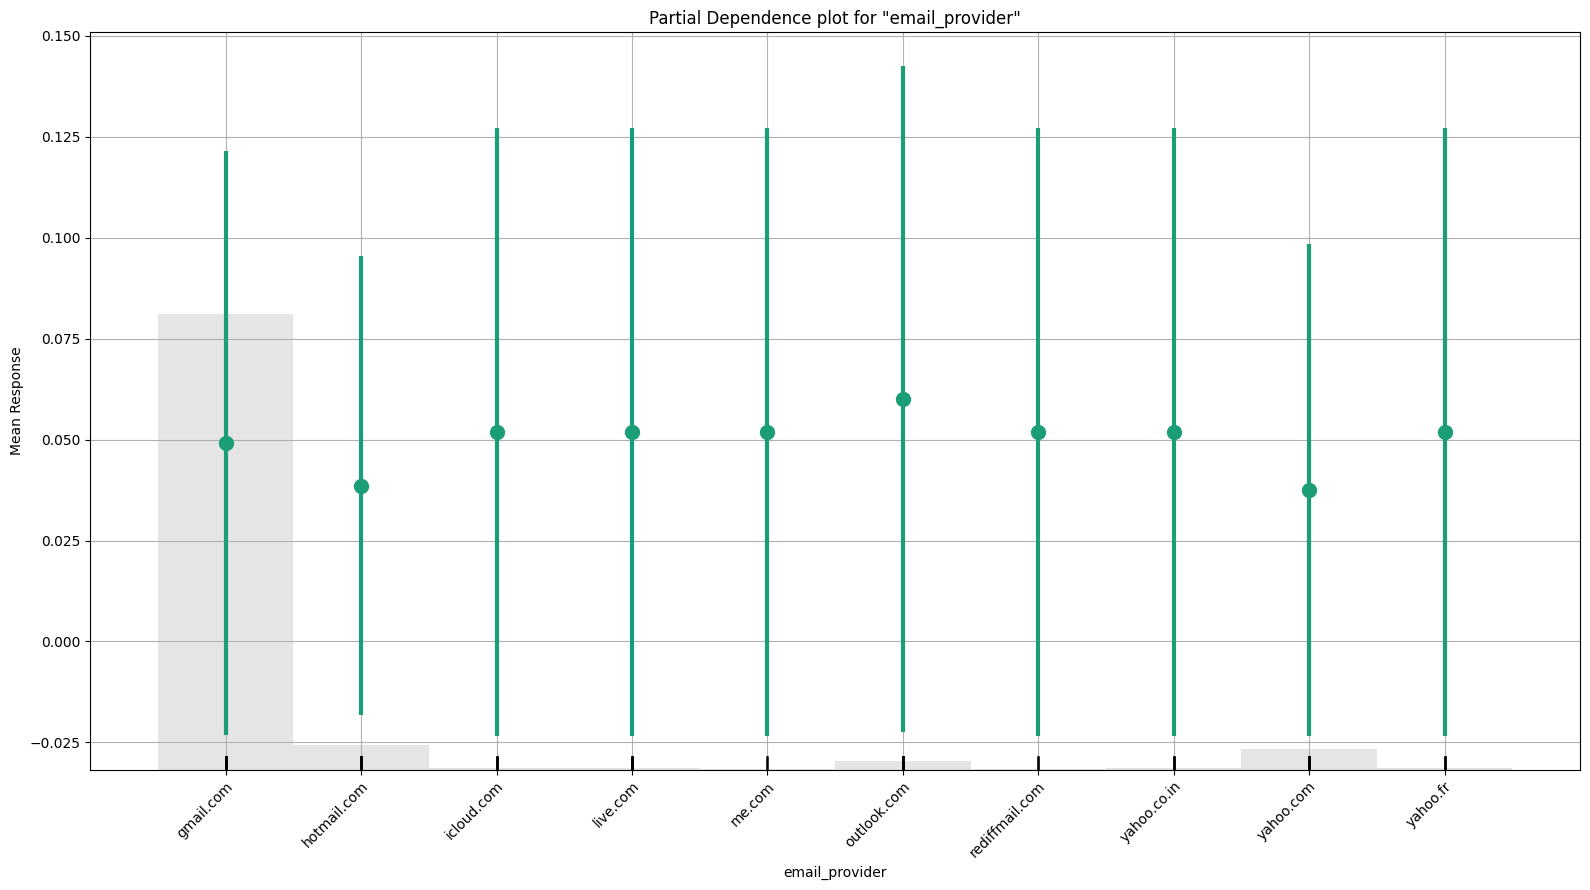

In [ ]:
best_model_h2o = h2o.load_model("/content/drive/MyDrive/ML/model/best_model_h2o")
best_model_h2o.explain(hf)

# 開始預測

## 進行預測

In [ ]:
predictions_df = best_model_h2o.predict(hf).as_data_frame()

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [ ]:
# 建立資料庫連線
sql_engine = sql.create_engine('sqlite:////content/drive/MyDrive/ML/database/leads_transactions.db')
# 將DataFrame存入leads_ltb_h2o的資料表
result = pd.concat([leads_df, predictions_df], axis=1).to_sql(
    'leads_ltb_h2o',
    con=conn, if_exists='replace', index=False
)
print(f'成功寫入 {result} 筆資料。')

成功寫入 19919 筆資料。


## 預測結果

- predict: 模型預測該潛在用戶是否會購買
  - `0`表示預測這個用戶**「不會購買」**產品。
  - `1`表示預測這個用戶**「會購買」**產品。
- p0: 用戶「不會購買」的機率
- p1: 用戶「會購買」的機率

In [ ]:
# 讀取資料表（例如：leads_ltb_h2o）
df = pd.read_sql('SELECT * FROM leads_ltb_h2o', con=sql_engine)

# 檢視前幾筆資料
df.head()

,mailchimp_id,user_full_name,user_email,member_rating,optin_time,country_code,made_purchase,optin_days,email_provider,predict,p0,p1
0,3,Garrick Langworth,garrick.langworth@gmail.com,2,2019-05-22 00:00:00.000000,in,1,-589,gmail.com,0,0.961327,0.038673
1,4,Cordell Dickens,cordell.dickens@gmail.com,4,2018-11-19 00:00:00.000000,other,1,-773,gmail.com,0,0.927102,0.072898
2,8,Inga Dach,inga.dach@gmail.com,2,2018-11-19 00:00:00.000000,other,1,-773,gmail.com,0,0.980488,0.019512
3,10,Ferdinand Bergstrom,ferdinand.bergstrom@gmail.com,2,2020-03-20 00:00:00.000000,co,1,-286,gmail.com,0,0.962787,0.037213
4,11,Justen Simonis,justen.simonis@gmail.com,2,2020-04-14 00:00:00.000000,other,0,-261,gmail.com,0,0.986231,0.013769


# 行銷跟進策略

評分等級|p1範圍|行銷策略方向|跟進策略方案|預算分配
-|-|-|-|-
Hot🔥|≥0.8|立即轉換|-提供限時獨享優惠或專屬折扣，如專屬優惠VIP限時折扣碼(72小時有效)。<br>-提供一對一線上免費諮詢或體驗試用。<br>-個性化電子郵件、LINE推播或專人電話聯繫。|50%
Warm🌤|0.6-0.8|價值建立|-提供教育性內容，如使用攻略、成功案例分享影片，來強化產品信任。<br>-透過輕鬆互動，如抽獎、問答活動，增加參與感及興趣。<br>-寄送產品使用體驗調查或試用小包裝，鼓勵提升興趣。|30%
Cold❄️|0.4-0.6|興趣喚醒|-提供基礎知識型內容，如新手教學、產品Q&A等，建立認知。<br>-使用趣味性遊戲或輕量互動式小測驗，增加潛在興趣。<br>-透過再行銷廣告反覆曝光，以加深印象。|15%
Non-Target🚫|<0.4|低成本跟進|-減少主動行銷資源，僅以自動化電子報定期聯絡。<br>-提供廣泛且普遍的內容，如部落格文章、常見問題集等，低成本維持品牌接觸點。|5%

In [ ]:
conditions = [
    df['p1'] >= 0.8,
    df['p1'].between(0.6, 0.8),
    df['p1'].between(0.4, 0.6),
    df['p1'] < 0.4
]
choices = ['Hot Lead', 'Warm Lead', 'Cold Lead', 'Non-Target']
df['lead_grade'] = np.select(conditions, choices)
df

,mailchimp_id,user_full_name,user_email,member_rating,optin_time,country_code,made_purchase,optin_days,email_provider,predict,p0,p1,lead_grade
0,3,Garrick Langworth,garrick.langworth@gmail.com,2,2019-05-22 00:00:00.000000,in,1,-589,gmail.com,0,0.961327,0.038673,Non-Target
1,4,Cordell Dickens,cordell.dickens@gmail.com,4,2018-11-19 00:00:00.000000,other,1,-773,gmail.com,0,0.927102,0.072898,Non-Target
2,8,Inga Dach,inga.dach@gmail.com,2,2018-11-19 00:00:00.000000,other,1,-773,gmail.com,0,0.980488,0.019512,Non-Target
3,10,Ferdinand Bergstrom,ferdinand.bergstrom@gmail.com,2,2020-03-20 00:00:00.000000,co,1,-286,gmail.com,0,0.962787,0.037213,Non-Target
4,11,Justen Simonis,justen.simonis@gmail.com,2,2020-04-14 00:00:00.000000,other,0,-261,gmail.com,0,0.986231,0.013769,Non-Target
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19914,33405,Ms. Felicity Moore MD,ms.felicity.moore.md@gmail.com,2,2018-11-18 00:00:00.000000,other,0,-774,gmail.com,0,0.988238,0.011762,Non-Target
19915,33406,Shirley Rowe,shirley.rowe@gmail.com,1,2019-03-12 00:00:00.000000,br,0,-660,gmail.com,0,0.950818,0.049182,Non-Target
19916,33407,Jarrett Walker-Carroll,jarrett.walkercarroll@gmail.com,2,2019-09-09 00:00:00.000000,in,0,-479,gmail.com,0,0.971380,0.028620,Non-Target
19917,33408,Tanja Herzog,tanja.herzog@gmail.com,2,2019-10-24 00:00:00.000000,other,0,-434,gmail.com,0,0.987937,0.012063,Non-Target


# 關閉連接

In [ ]:
conn.close()
h2o.cluster().shutdown(prompt=False)

H2O session _sid_bd35 closed.
